# Load libraries, set preferred plotting parameters, and define the preferred colorbar

In [6]:
import numpy as np
import proplot as pplt
import xarray as xr
import scipy.stats as stats
from global_land_mask import globe

# Import the user defined functions useful for analyses and plotting
from functions import (detrend_dim, remove_seasonal_cycle, generate_subplot,
                       stand, lag_linregress_3D, land_mask, high_pass_filter
                       )

pplt.rc.update(fontsize=14)
pplt.rc['savefig.dpi'] = 300
# cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')
reds = pplt.Colormap('fire', alpha=[0.5, 1, 1, 1])
blues = pplt.Colormap('Blues_r', alpha=[1, 1, 1, 0.5])

# Create the custom colormap
colors = blues(np.linspace(0, 1, 128))
colors = np.vstack((colors, [[1, 1, 1, 1]] * 20))  # Add more white in the middle
colors = np.vstack((colors, reds(np.linspace(0, 1, 128))))
divCmap = pplt.Colormap(colors)

# Define the user's desired regions of interest

In [3]:
# Define the broader regions of interest, both the labels and the bounding latitudes and longitudes
# The order of these variables (regionLabels, region, regionInd) impacts the order in which they appear in the plotting command.
# Users can change the lat/lon bounding coordinates to apply this regression analysis to any region on the globe.

regionLabels = ['Gulf Stream', 'Kuroshio-Oyashio', 'Agulhas', 'Brazil-Malvinas']
regionHemisphere = ['North', 'North', 'South', 'South']

region = [None, None, None, None, None] 
region[0] = {'lats': 19,  'latn': 58,  'lonw': 268,   'lone': 344}     # Gulf stream
region[1] = {'lats': 20,  'latn': 55,  'lonw': 119,   'lone': 215}     # Kuroshio-Oyashio Extension
region[2] = {'lats': -56, 'latn': -23, 'lonw': 2,     'lone':  92}     # Agulhas
region[3] = {'lats': -60, 'latn': -24, 'lonw': 284.9, 'lone': 350}     # Malvinas

# Define smaller regions of interest, which tightly encapsulate the western boundary currents for purpose of area-averaging
regionInd = [None, None, None, None, None]
regionInd[0] = {'lats': 35,  'latn': 45,  'lonw': 280, 'lone': 310}     # Gulf stream
regionInd[1] = {'lats': 31,  'latn': 45,  'lonw': 140, 'lone': 170}     # Kuroshio-Oyashio Extension
regionInd[2] = {'lats': -45, 'latn': -35, 'lonw': 11,  'lone': 60}      # Agulhas
regionInd[3] = {'lats': -50, 'latn': -35, 'lonw': 305, 'lone': 320}     # Malvinas

numRegions = np.shape(regionLabels)[0]


# Read in, detrend, remove seasonal cycle, and spatially filter the data

## Read in data

In [3]:
path = '/glade/work/jamesl/ERA5/'

SST = xr.open_dataset(path+'ERA5.h0.SST.197901-202309.nc')['SST'].sel(time=slice('2008', '2010'))
w = xr.open_dataset(path+'ERA5.h0.w.197901-202309.nc')['w']*1000  # convert from m/s to mm/s
w.attrs['units'] = 'mm/s'
PRECT = xr.open_dataset(path+'ERA5.h0.PRECT.197901-202309.nc')['PRECT'].sel(time=slice('2008', '2010'))


## Remove linear trend from data as a function of gridpoint

In [4]:
SSTdet = detrend_dim(SST, 'time')
wdet = detrend_dim(w, 'time')
PRECTdet = detrend_dim(PRECT, 'time')

## Remove seasonal cycle to create anomalies

In [5]:
SSTdetAnom = remove_seasonal_cycle(SSTdet)
wdetAnom = remove_seasonal_cycle(wdet)
PRECTdetAnom = remove_seasonal_cycle(PRECTdet)

## Spatially high pass filter precipitation data to remove effects of synoptic storms

In [6]:
PRECTdetAnomHPfilt = high_pass_filter(data=PRECTdetAnom, window_size=41,)

# Or, if the above processing steps have already been completed, read in the processed data

In [4]:
path = '/glade/work/jamesl/ERA5/'
SSTdetAnom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                             )['SST']
wdetAnom = xr.open_dataset(path+'ERA5.h0.w.detrended.anomalies.mmPerSec.197901-202309.nc'
                           )['w']
PRECTdetAnomHPfilt = xr.open_dataset(path+'ERA5.h0.PRECT.detrended.anomalies.1000kmHighPassFiltered.200701-202309.nc'
                                     )['PRECT']

# Calculate and plot the standard deviation of SST anomalies and the regression of anomalous w$_{850}$ and PRECT onto SST anomalies

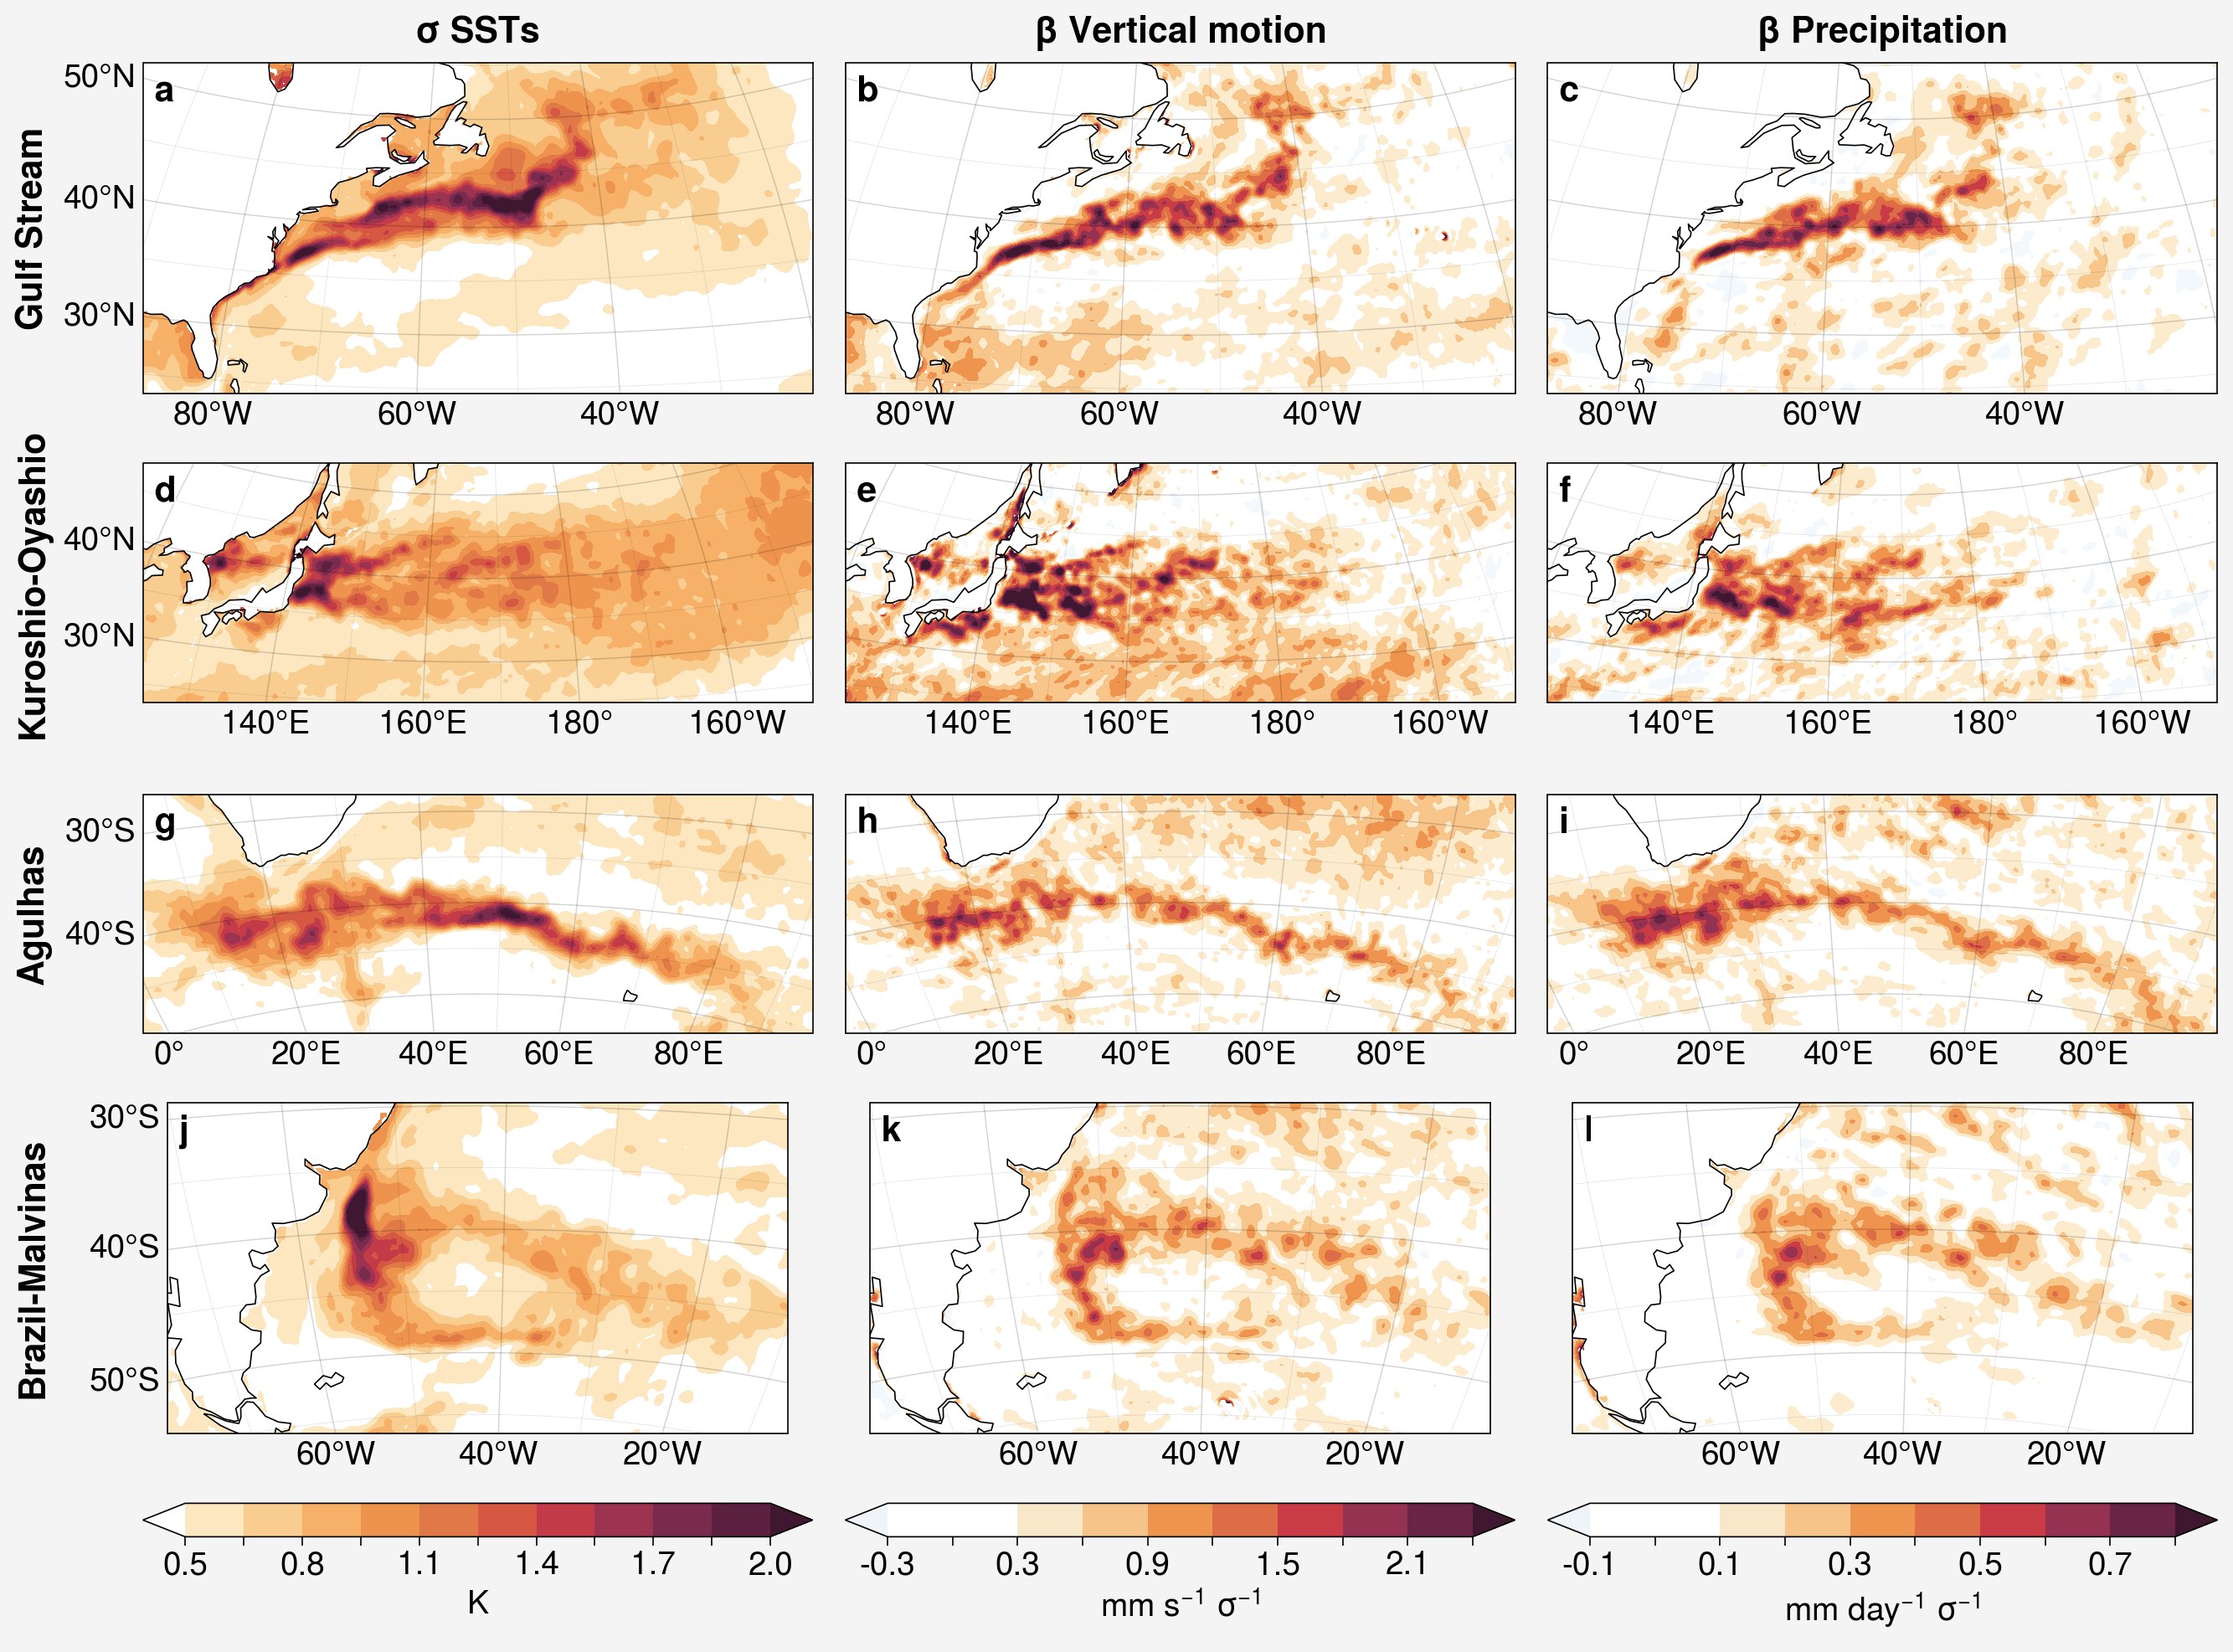

In [5]:
# Set up the grid for the plots and create the figure with a reference width for the subplots
gs = pplt.GridSpec(ncols=3, nrows=4)
fig = pplt.figure(refwidth=4)

# Define the contour levels for the plots
lvlsSST = np.arange(0.5, 2.1, 0.15)
lvlsW = np.arange(-0.3, 2.41, 0.3)
lvlsPrect = np.arange(-0.1, 0.81, 0.1)
normW = pplt.Norm('diverging', fair=True, vmin=-0.3, vcenter=0, vmax=2.1)
normPrect = pplt.Norm('diverging', fair=True, vmin=-0.1, vcenter=0, vmax=0.7)

# Iterate through each user-defined region
# Each iteration will perform and plot a regression analysis for the region of interest
for ii, val in enumerate(regionLabels):

    # Determine the winter months depending on which hemisphere the region of interest is located in
    if regionHemisphere[ii] == 'North':
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif regionHemisphere[ii] == 'South':
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]

    # Select the regions of interest (roi)
    SST_roi = SSTdetAnom.sel(time=dateE,
                             lon=slice(region[ii]['lonw'], region[ii]['lone']),
                             lat=slice(region[ii]['lats'], region[ii]['latn'])
                             )
    # Mask out the lakes in land regions
    SST_roi = SST_roi.where(land_mask(SST_roi))

    w_roi = wdetAnom.sel(time=dateE, level=850,
                         lon=slice(region[ii]['lonw'], region[ii]['lone']),
                         lat=slice(region[ii]['lats'], region[ii]['latn'])
                         )

    prect_roi = PRECTdetAnomHPfilt.sel(time=dateE,
                                       lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                       lat=slice(region[ii]['lats'], region[ii]['latn'])
                                       )
    # Preallocate regression arrays
    wReg = w_roi[0].copy(deep=True)
    prectReg = prect_roi[0].copy(deep=True)

    # Index the winter months and standardize SST anomalies
    data  = w_roi[w_roi['time.month'].isin(months)]
    data1 = stand(SST_roi[SST_roi['time.month'].isin(months)])
    # Regress anomalous vertical motion onto standardized SST anomlies
    wReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data  = prect_roi[prect_roi['time.month'].isin(months)]
    data1 = stand(SST_roi[SST_roi['time.month'].isin(months)])
    prectReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    # Perform standard deviation
    data = SST_roi[SST_roi['time.month'].isin(months)].std('time')

    # Plot the data in each column
    ax = generate_subplot(fig, gs[ii, 0], region[ii])
    l = ax.contourf(data, levels=lvlsSST, extend='both', cmap='fire')

    ax = generate_subplot(fig, gs[ii, 1], region[ii], latlabels=False)
    m = ax.contourf(wReg, levels=lvlsW, extend='both', cmap=divCmap, norm=normW)

    ax = generate_subplot(fig, gs[ii, 2], region[ii], latlabels=False)
    n = ax.contourf(prectReg, levels=lvlsPrect, extend='both', cmap=divCmap, norm=normPrect)


fig.format(rowlabels=regionLabels,
           collabels=['σ SSTs', 'β Vertical motion', 'β Precipitation'])

# Add colorbars and ensure that the tick labels are neat and at a consistent spacing
tlabels = [str(np.round(val, decimals=1)) for val in lvlsSST]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(l, loc='b', label='K', col=1, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsW]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(m, loc='b', label='mm s$^{-1}$ σ$^{-1}$', col=2, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm day$^{-1}$ σ$^{-1}$', col=3, ticklabels=tlabels)

# fig.save('stdDevOfAnomalousSST_regressonOfw850_PRECT-detrended-ERA5-LarsonThompsonHurrell2024.pdf')


# Calculate and plot the vertical profile of anomalous vertical motion regressed onto SST anomalies

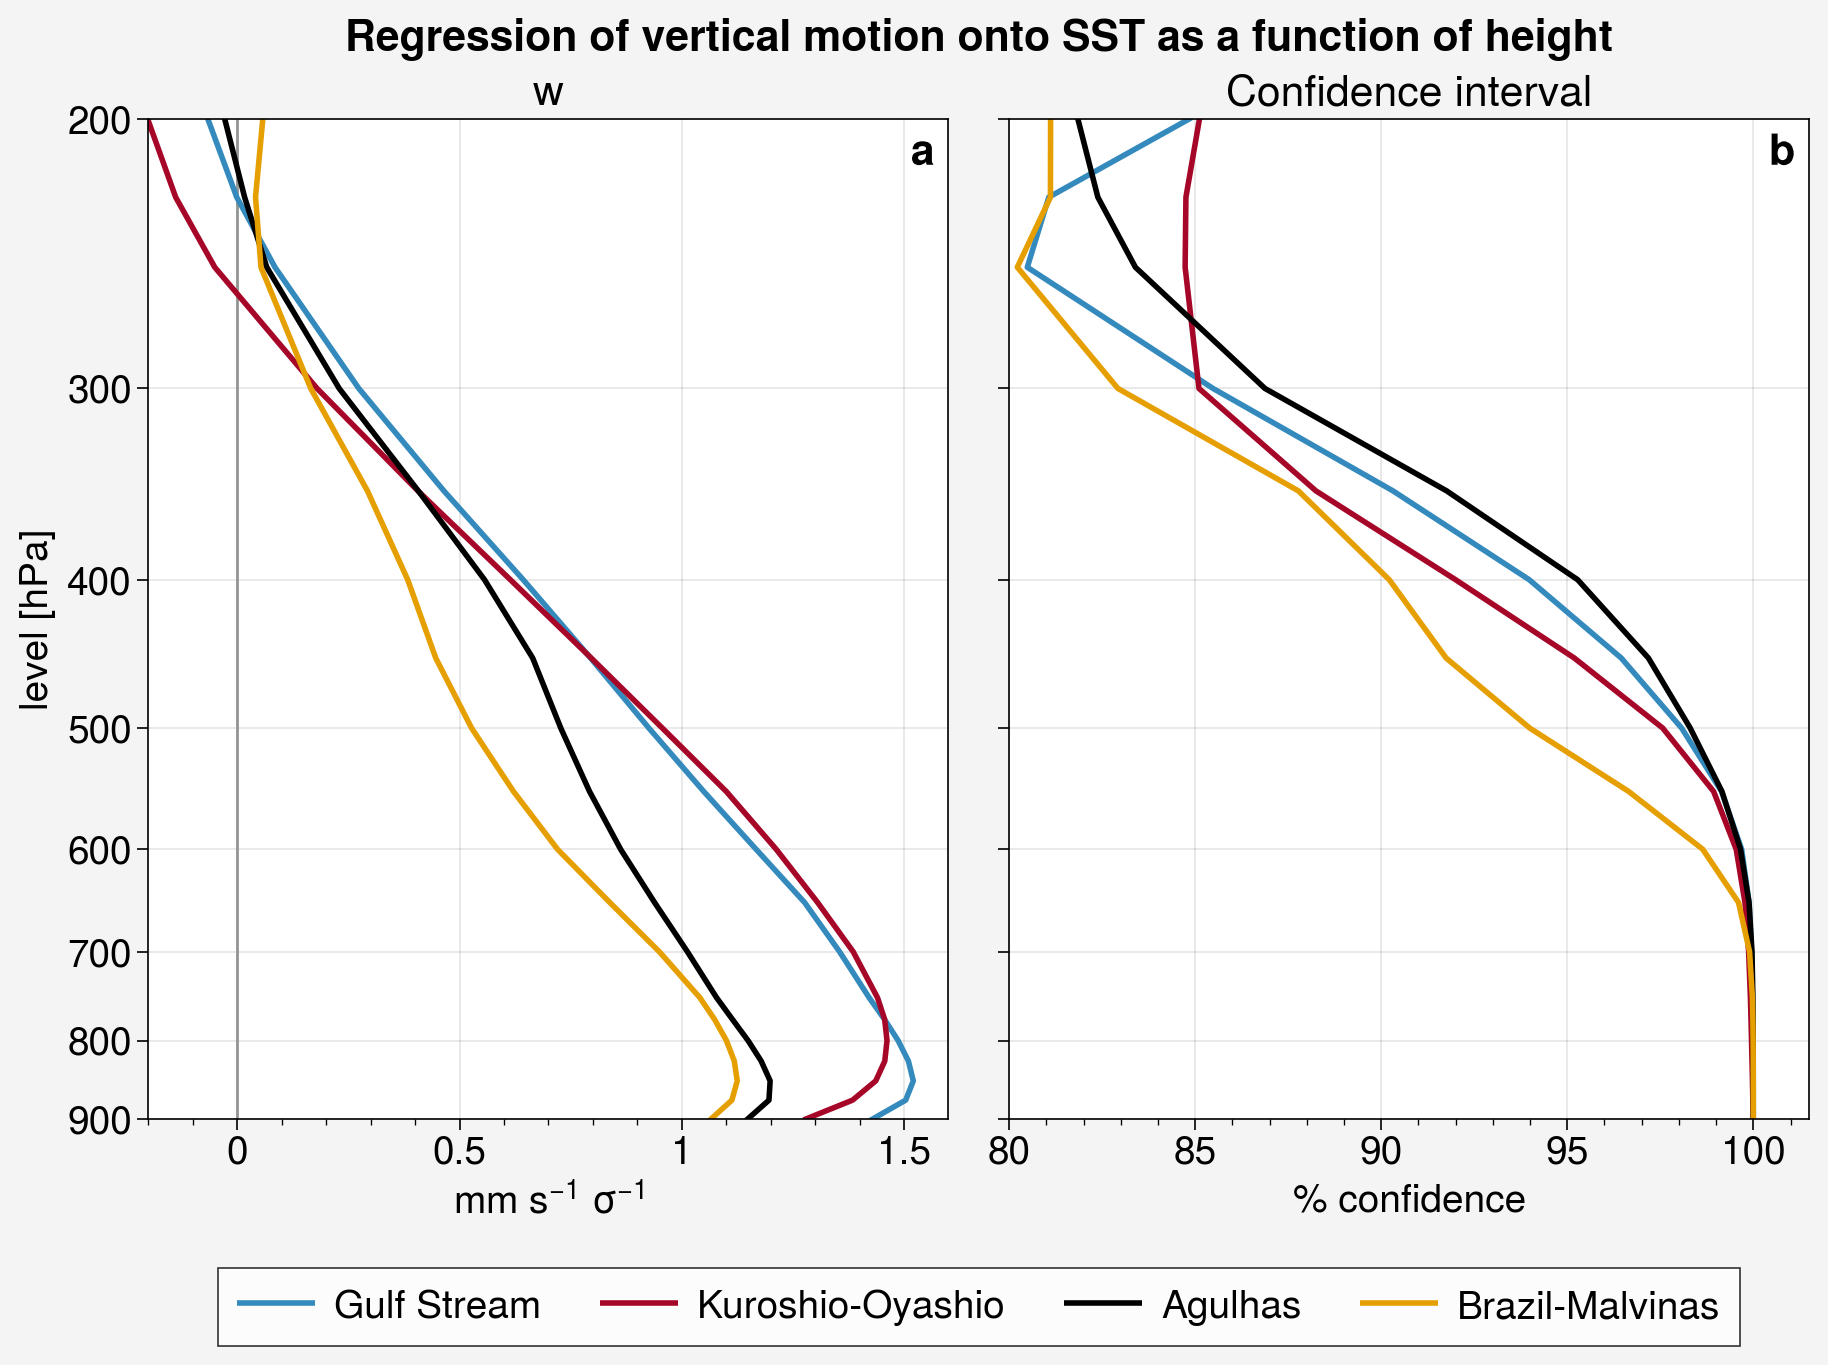

In [25]:
# Create the figure with specified reference width, aspect ratio, and shared x-axis
fig = pplt.figure(refwidth=4, refaspect=0.8, sharex=False,
                  suptitle='Regression of vertical motion onto SST as a function of height')
# Create subplots with reversed y-axis and logarithmic scale for y-axis
axs = fig.subplots(ncols=2, yreverse=True, yscale='log', yticks=True, 
                   ylabel='level [hPa]', abc=True, abcloc='ur')

# Degrees of freedom 
# Calculated in another script based on 16 years of data and combined autoregression of ocean and atmospheric states
dof = 88

# Plot vertical grey lines at 0 for reference
axs[0].vlines(0, 200, 900, c='grey', lw=1)
axs[1].vlines(0, 200, 900, c='grey', lw=1)

# Define colors for plotting each region
colors = ['#348abdff', '#a60628ff', 'k', '#E69F00']

# Iterate through each region of interest
for ii, iiVal in enumerate(regionLabels):

    # Determine the winter months depending on which hemisphere the region of interest is located in
    if regionHemisphere[ii] == 'North':
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif regionHemisphere[ii] == 'South':
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]

    # First, create a consistent spatial mask to apply to all vertical levels of w
    # Make this spatial mask based on a regression threshold, to capture the core of the western boundary currents
    SST_roi = SSTdetAnom.sel(time=dateE,
                             lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                             lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])
                             )

    w_roi = wdetAnom.sel(time=dateE, level=slice(200, 900),
                         lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                         lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])
                         )

    # Index the winter months and the vertical level of the iteration
    data  = w_roi[w_roi['time.month'].isin(months)].sel(level=850)
    data1 = stand(SST_roi[SST_roi['time.month'].isin(months)])
    # Regress anomalous vertical motion onto standardized SST anomalies
    # The spatial mask is based on a threshold of 0.8 mm/s/σ regression
    wMask = lag_linregress_3D(data1.values, data.values)[2] > 0.8

    # Preallocate arrays for storing regressions as a function of height
    wTvals = w_roi[0, 0].copy(deep=True)
    wReg   = w_roi[0, 0].copy(deep=True)
    wRegAvg   = np.zeros(w_roi['level'].size)
    wTvalsAvg = np.zeros(w_roi['level'].size)

    # Iterate through each vertical level of vertical motion
    # In each iteration, calculate a spatial average of gridpoint regressions and Student's t-values for statistical significance
    for zz, levVal in enumerate(w_roi['level']):

        # Index the winter months and the vertical level of the iteration
        data  = w_roi[w_roi['time.month'].isin(months)][:, zz]
        data1 = stand(SST_roi[SST_roi['time.month'].isin(months)])
        # Regress anomalous vertical motion onto standardized SST anomalies
        wTvals[:, :], wReg[:, :] = lag_linregress_3D(data1.values, data.values)[1:3]

        # Calculate the t statistic based on gridpoint correlations
        wTvals = wTvals*np.sqrt(dof-2)/np.sqrt(1-wTvals**2)

        # Calculate area averaged regression values
        wRegAvg[zz] = wReg.where(wMask
                                 ).weighted(np.cos(np.deg2rad(wReg.lat))
                                            ).mean(['lat', 'lon']).values

        # Calculate area averaged t values
        wTvalsAvg[zz] = np.sqrt((wTvals**2).where(wMask
                                                  ).weighted(np.cos(np.deg2rad(wTvals.lat))
                                                             ).mean(['lat', 'lon'])
                                )

    axs[0].plot(wRegAvg, w_roi['level'].values, c=colors[ii], lw=2, label=regionLabels[ii])
    axs[1].plot(stats.t.cdf(wTvalsAvg, loc=0, scale=1, df=dof)*100, w_roi['level'].values, c=colors[ii], lw=2)

    axs[0].format(xlabel='mm s$^{-1}$ σ$^{-1}$', xlim=(-0.2, 1.6), title='w')
    axs[1].format(xlabel='% confidence', xlim=(80, 101.5), title='Confidence interval')

fig.legend(loc='b', ncols=4)

# fig.save('figures/verticalProfileOfOmegaRegression-88dof-ERA5-LarsonThompsonHurrell2024a.pdf')
